<a href="https://colab.research.google.com/github/zhuhel/NER_CN_test/blob/master/NER_CN_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read datasets and tags

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
input_dir = "/content/gdrive/My Drive/Chinese_NER/"

data = pd.read_csv(input_dir+"train.tsv", delimiter='\t', header=None, names=['text','label'])
data.head(10)

,text,label
0,text_a,label
1,海钓比赛地点在厦门与金门之间的海域。,OOOOOOOB-LOCI-LOCOB-LOCI-LOCOOO...
2,这座依山傍水的博物馆由国内一流的设计师主持设计...,OOOOOOOOOOOOOOOOOOOOOOO...
3,但作为一个共产党员、人民公仆，应当胸怀宽阔，真...,OOOOOOOOOOOOOOOOOOOOOOO...
4,在发达国家，急救保险十分普及，已成为社会保障体...,OOOOOOOOOOOOOOOOOOOOOOO...
5,日俄两国国内政局都充满变数，尽管日俄关系目前是...,B-LOCB-LOCOOOOOOOOOOOOOOB-LOC...
6,克马尔的女儿让娜今年读五年级，她所在的班上有3...,B-PERI-PERI-PEROOOB-PERI-PEROOOOO...
7,参加步行的有男有女，有年轻人，也有中年人。,OOOOOOOOOOOOOOOOOOOOO
8,沙特队教练佩雷拉：两支队都想胜，因此都作出了最...,B-ORGI-ORGI-ORGOOB-PERI-PERI-PEROOO...
9,这种混乱局面导致有些海域使用者的合法权益难以得...,OOOOOOOOOOOOOOOOOOOOOOO...


In [ ]:
texts = data.text.values[1:]
labels = data.label.values[1:]

In [ ]:
combined_text, combined_tags, list_tags = [], [], []
for txt, lab in zip(texts, labels):
  return_texts = txt.split('\x02')
  return_tags = lab.split('\x02')
  ## separate sentences
  ind_end = -1
  for it, txt in enumerate(return_texts):
    if txt == '；' or txt == '。':
      combined_text += [return_texts[ind_end+1:it]]
      combined_tags += [return_tags[ind_end+1:it]]
      ind_end = it
  #combined_text.append(return_texts)
  #combined_tags.append(return_tags)
  list_tags += return_tags

#print(combined_text[:2])
#print(combined_tags[:2])
#print(list_tags[:10])

# Encode (digitize) text and tags

In [ ]:
#install the amazing transformers package by huggingface
!pip install transformers

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
## setup GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [ ]:
## extract subset(s) of token, improve f1 from 0.55 to 0.7 (amazing?)
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
## compare the difference
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(combined_text, combined_tags)
]
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
combined_text = tokenized_texts
combined_tags = labels

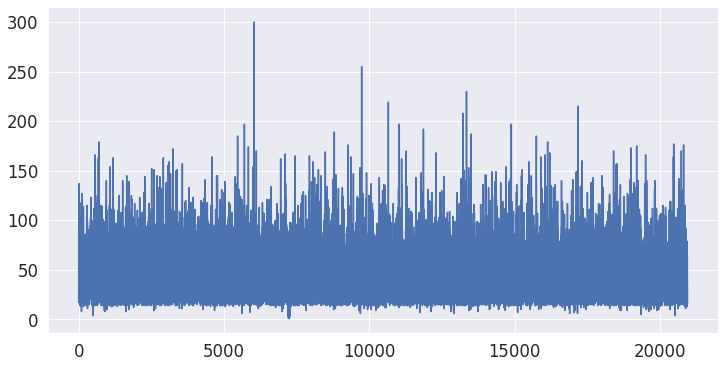

In [ ]:
text_len = []
for txt in combined_text:
  text_len.append(len(txt))
  if len(txt)>500:
    print(txt)

plt.plot(text_len)
plt.show()

In [ ]:
MAX_LEN = 256
bs = 16
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in combined_text],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tag_values = list(set(list_tags))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

print(tag_values)

['B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'B-ORG', 'O', 'I-LOC', 'PAD']


In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in combined_tags],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

tags[0]

array([5, 5, 5, 5, 5, 5, 5, 2, 6, 5, 2, 6, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [ ]:
print(combined_text[0])
print(input_ids[0])

['海', '钓', '比', '赛', '地', '点', '在', '厦', '门', '与', '金', '门', '之', '间', '的', '海', '域']
[3862 7157 3683 6612 1765 4157 1762 1336 7305  680 7032 7305  722 7313
 4638 3862 1818    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0  

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
# split data for trainning (tr_) and validation (val_), here use keras (tensorflow backend)
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
# convert data to torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
# The last step is to define the dataloaders. We shuffle the data at training time with the RandomSampler and at test time we just pass them sequentially with the SequentialSampler.
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

# Setup the Bert model for finetuning


In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'3.0.2'

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-chinese",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-c

In [ ]:
model.cuda();

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=2e-5,
    eps=1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Training: fit BERT for named entity recognition

In [ ]:
!pip install seqeval
from seqeval.metrics import f1_score, accuracy_score

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from tqdm import tqdm, trange
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []
f1_values, validation_f1_values = [], []
acc_values, validation_acc_values = [], []

total_t0 = time.time()
for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Measure how long the training epoch takes.
    t0 = time.time()
    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0
    tr_pred , tr_true_labels = [], []


    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()

        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

        # Move logits and labels to CPU
        tr_logits = outputs[1].detach().cpu().numpy()
        tr_label = b_labels.to('cpu').numpy()
        tr_pred.extend([list(p) for p in np.argmax(tr_logits, axis=2)])
        tr_true_labels.extend(tr_label)
        

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Train loss: {}".format(avg_train_loss))
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    tr_pred_tags = [tag_values[p_i] for p, l in zip(tr_pred, tr_true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    train_tags = [tag_values[l_i] for l in tr_true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    train_acc = accuracy_score(tr_pred_tags, train_tags)
    train_f1 = f1_score(tr_pred_tags, train_tags)
    print("Train Accuracy: {}".format(train_acc))
    print("Train F1-Score: {}".format(train_f1))
    acc_values.append(train_acc)
    f1_values.append(train_f1)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")
    t0 = time.time()

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    valid_acc = accuracy_score(pred_tags, valid_tags)
    valid_f1 = f1_score(pred_tags, valid_tags)
    print("Validation Accuracy: {}".format(valid_acc))
    print("Validation F1-Score: {}".format(valid_f1))
    validation_acc_values.append(valid_acc)
    validation_f1_values.append(valid_f1)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    print("  Validation took: {:}".format(validation_time))
    print()

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.07590362352917035
Train Accuracy: 0.9780737488449802
Train F1-Score: 0.7793575743298953
  Training epcoh took: 0:07:53

Running Validation...
Validation loss: 0.03121079602065489


Epoch:  20%|██        | 1/5 [08:09<32:37, 489.46s/it]

Validation Accuracy: 0.9902289070648296
Validation F1-Score: 0.9113420972179762
  Validation took: 0:00:17

Train loss: 0.022076847839954786
Train Accuracy: 0.993381327110089
Train F1-Score: 0.9238373783501805
  Training epcoh took: 0:07:53

Running Validation...
Validation loss: 0.027774734578969826


Epoch:  40%|████      | 2/5 [16:19<24:28, 489.66s/it]

Validation Accuracy: 0.9926442334083548
Validation F1-Score: 0.9301175015460731
  Validation took: 0:00:17

Train loss: 0.010772257664680195
Train Accuracy: 0.9967337681023921
Train F1-Score: 0.9569630671101814
  Training epcoh took: 0:07:51

Running Validation...
Validation loss: 0.03072616318873937


Epoch:  60%|██████    | 3/5 [24:27<16:17, 488.99s/it]

Validation Accuracy: 0.9921392106274359
Validation F1-Score: 0.932577382776586
  Validation took: 0:00:17

Train loss: 0.005197026996927231
Train Accuracy: 0.9983996677914323
Train F1-Score: 0.976386072251057
  Training epcoh took: 0:07:50

Running Validation...
Validation loss: 0.03420780991574657


Epoch:  80%|████████  | 4/5 [32:33<08:08, 488.26s/it]

Validation Accuracy: 0.9931492561892737
Validation F1-Score: 0.9413930653574717
  Validation took: 0:00:17

Train loss: 0.003046765086993273
Train Accuracy: 0.999170692793284
Train F1-Score: 0.9873932212730779
  Training epcoh took: 0:07:49

Running Validation...
Validation loss: 0.036174865736515446


Epoch: 100%|██████████| 5/5 [40:39<00:00, 487.95s/it]

Validation Accuracy: 0.9932590437503431
Validation F1-Score: 0.9408329491317042
  Validation took: 0:00:17


Training complete!
Total training took 0:40:40 (h:mm:ss)


In [ ]:
import os
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/gdrive/My Drive/Chinese_NER/model_save_2/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to /content/gdrive/My Drive/Chinese_NER/model_save_2/


('/content/gdrive/My Drive/Chinese_NER/model_save_2/vocab.txt',
 '/content/gdrive/My Drive/Chinese_NER/model_save_2/special_tokens_map.json',
 '/content/gdrive/My Drive/Chinese_NER/model_save_2/added_tokens.json')

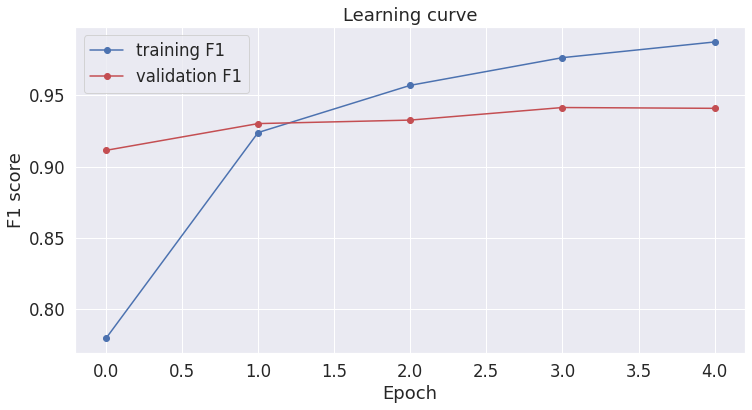

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(f1_values, 'b-o', label="training F1")
plt.plot(validation_f1_values, 'r-o', label="validation F1")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.legend()

plt.show()